In [107]:
from DiffeoOUT import *
from utils import *
import torch
import time 
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

In [108]:
m=32

x = torch.linspace(-1,1,m)
y = torch.linspace(-1,1,m)
grid = torch.zeros((1,m,m,2)).to(dtype=torchdtype, device=torchdeviceId)
for i in range(0,m):
        for j in range(0,m):
            grid[0,i,j,0]= x[i]
            grid[0,i,j,1]= y[j]

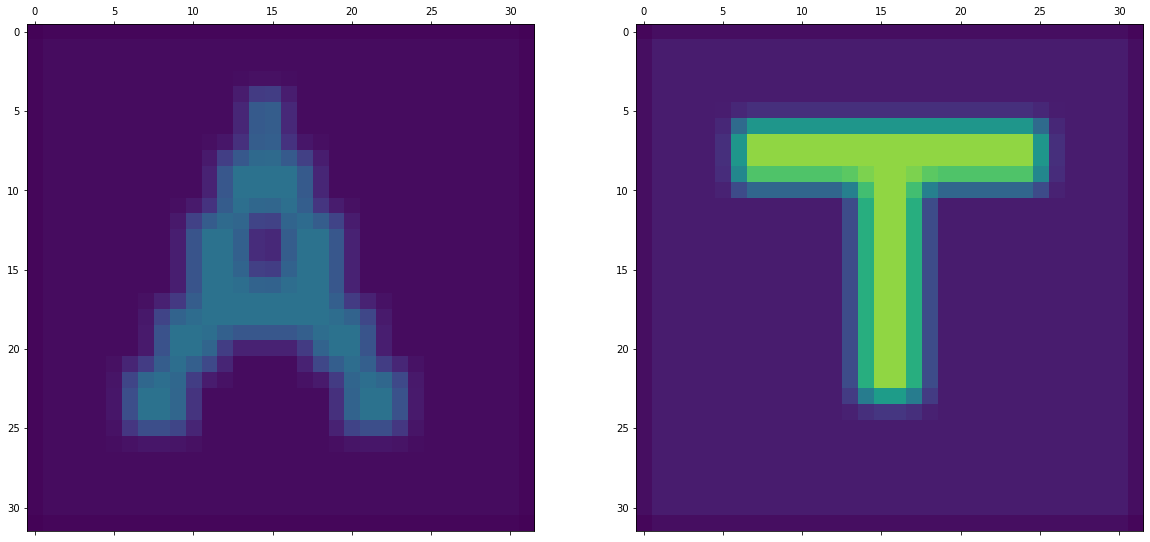

In [109]:
mu_2 = load_dist("T.png",grid)*2
G1=torch.Tensor([[2,0],[0,2]]).to(dtype=torchdtype, device=torchdeviceId)
mu_1 = load_dist("A.png",grid)
plot_pair(mu_1,mu_2)

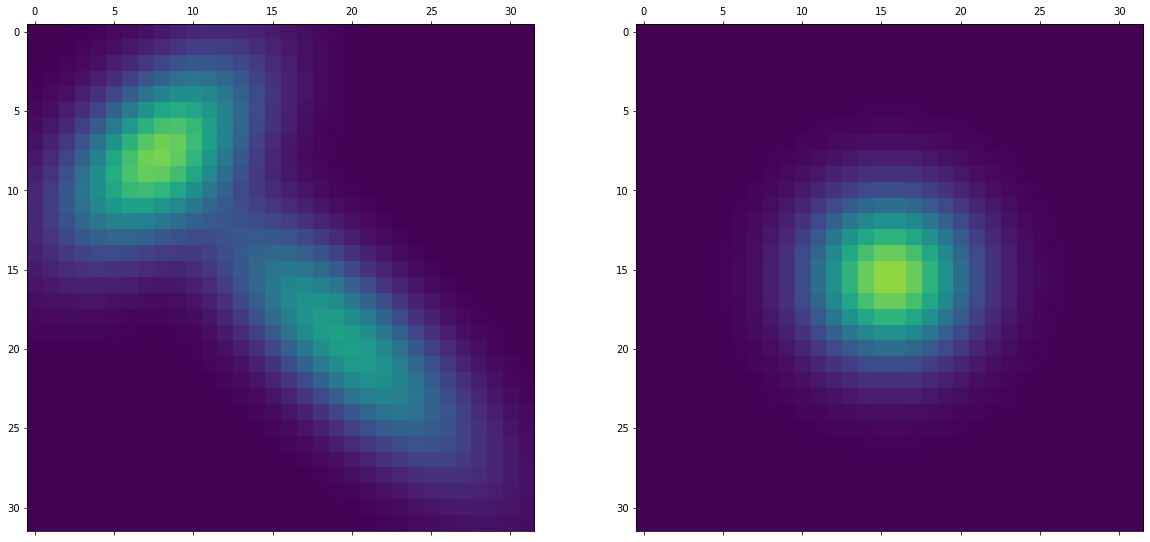

In [110]:
G1=torch.Tensor([[10,0],[0,10]]).to(dtype=torchdtype, device=torchdeviceId)
G2=torch.Tensor([[10,10],[0,10]]).to(dtype=torchdtype, device=torchdeviceId)
G3=torch.Tensor([[10,-15],[0,10]]).to(dtype=torchdtype, device=torchdeviceId)
mu_2 = gaussian(0,0,G1,grid)

mu_1 = 2*normalize(gaussian(-.5,-.5,G2,grid)+gaussian(.25,.25,G3,grid))

plot_pair(mu_1,mu_2)

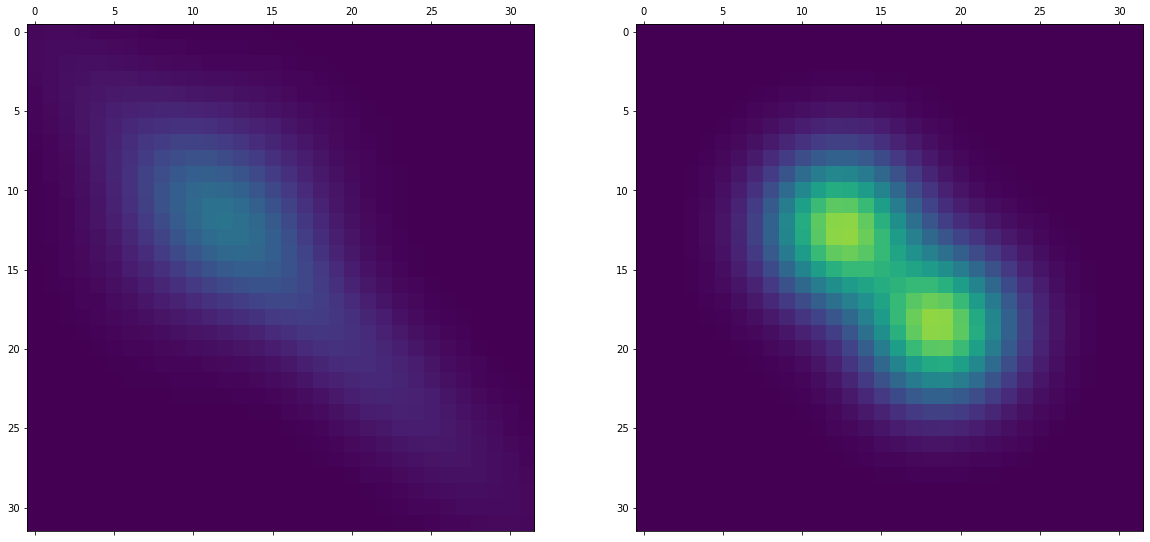

In [111]:
G1=torch.Tensor([[12,0],[0,12]]).to(dtype=torchdtype, device=torchdeviceId)
G2=torch.Tensor([[10,-18],[0,10]]).to(dtype=torchdtype, device=torchdeviceId)
G3=torch.Tensor([[7,0],[0,7]]).to(dtype=torchdtype, device=torchdeviceId)
mu_2 = 2*normalize(gaussian(.2,.2,G1,grid)+ gaussian(-.2,-.2,G1,grid))

mu_1 = normalize(gaussian(0,0,G2,grid)+gaussian(-.25,-.25,G3,grid))

plot_pair(mu_1,mu_2)

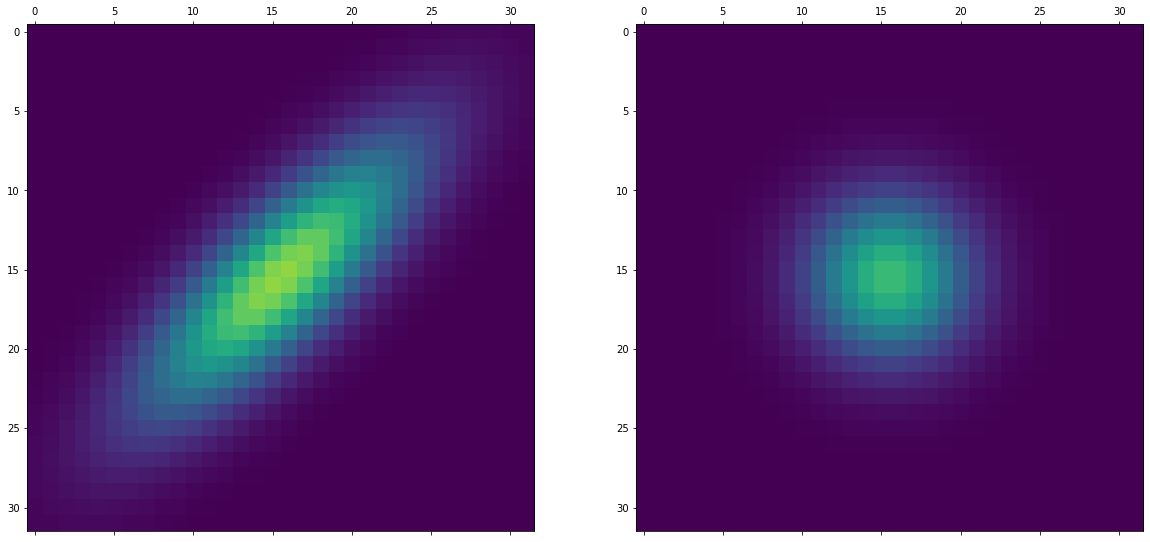

In [138]:
G1=torch.Tensor([[10,0],[0,10]]).to(dtype=torchdtype, device=torchdeviceId)
G2=torch.Tensor([[10,16],[0,10]]).to(dtype=torchdtype, device=torchdeviceId)
G3=torch.Tensor([[10,-16],[0,10]]).to(dtype=torchdtype, device=torchdeviceId)
mu_2 = (1/2)*gaussian(0,0,G1,grid)

mu_1 = normalize(gaussian(0,0,G2,grid))

plot_pair(mu_1,mu_2)

In [139]:
params=[]
params+=[{'T':6, 'match_coeff':1000, 'path_coeff':1}]
delta=1

In [140]:
def L(out):
    out=torch.unsqueeze(out,0)
    weight = torch.Tensor([[[[0,1,0],[1,-4,1],[0,1,0]]]]).to(dtype=torchdtype, device=torchdeviceId)/4
    #out = tnn.conv2d(out,weight.repeat(2,1,1,1), padding='same',groups=2)
    #out = tnn.conv2d(out,weight.repeat(2,1,1,1), padding='same',groups=2)
    #out = tnn.conv2d(out,weight.repeat(2,1,1,1), padding='same',groups=2)
    #out = tnn.conv2d(out,weight.repeat(2,1,1,1), padding='same',groups=2)
    #out = tnn.conv2d(out,weight.repeat(2,1,1,1), padding='same',groups=2)
    return out

In [141]:
def inner_prod(X,source,p,grid):
    pm=p[0,0]
    pX= pm*X.transpose(0,2)
    return ((L(pX)**2).sum(dim=0)/(pm)).sum() 

In [142]:
start =time.time()
vecs,funs = DiffeoOUT_multires(mu_1,mu_2,grid,params,inner_prod,delta)
print(time.time()-start)
pl_pathlength = path_length(mu_1,vecs,funs,grid,inner_prod,delta)
print(pl_pathlength)
N=vecs.shape[0]

0.8239622116088867
[0.11594939 0.10916486 0.12030851 0.13991696 0.18213244]


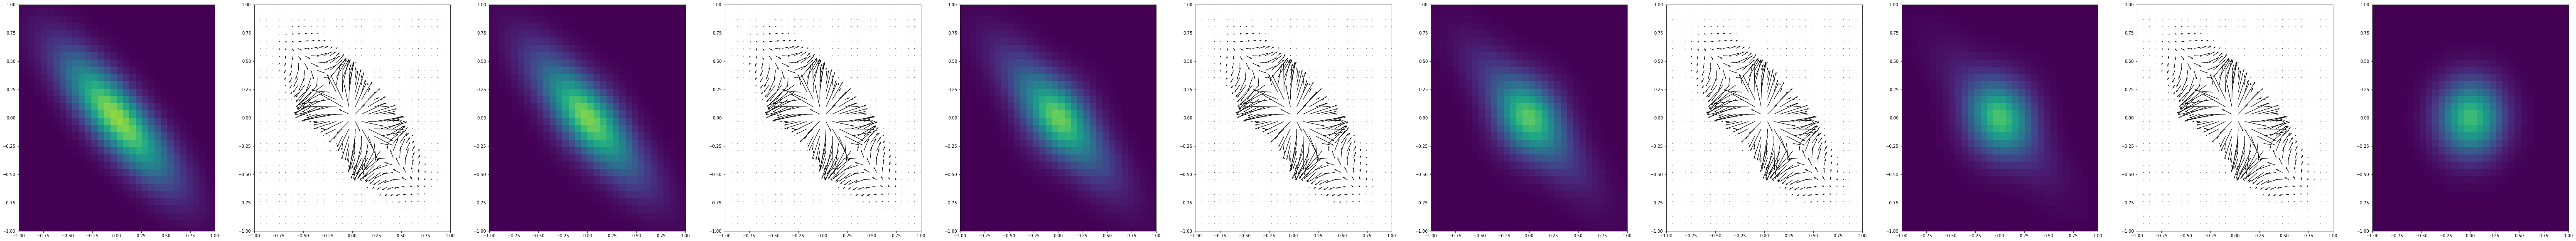

In [143]:
ls = make_and_plot_sequence_u(mu_1,mu_2,vecs,funs, grid)
save_gif(mu_1,mu_2,ls)

In [144]:
print(2*delta*pl_pathlength.sum()/pl_pathlength.shape[0])

0.26698886934884647


In [145]:
def kl(p, q):
    logpq = np.log((p + 1e-100) / (q + 1e-100))
    kl = (p * logpq + q - p).sum()

    return kl

def klobjective(plan, M, a,b, reg_m=1):
    f=(plan*M).sum()
    f+=kl(plan.sum(axis=1),a)
    f+=kl(plan.sum(axis=0),b)
    return f  

In [148]:
import ot
reg=.075
a=mu_1[0,0].reshape(m*m).cpu().numpy()
b=mu_2[0,0].reshape(m*m).cpu().numpy()
supports = grid.reshape(m*m,1,2)
M=((supports-supports.transpose(0,1))**2).sum(dim=2).cpu().numpy()/(delta)
M[M>=np.pi]=np.pi/2
M=np.cos(M)
M[M<=0]=1e-100
M=-1*np.log(M)
plan,log=ot.unbalanced.sinkhorn_unbalanced(a, b, M, reg, 1,numItermax=2000, stopThr=1e-6,log=True)

Wd=delta*np.sqrt(klobjective(plan,M,a,b))
print(Wd)

0.5112004990087211


In [131]:
import BCMSolver as BCM
S=BCM.BCMSolver(False)
a=mu_1[0,0].reshape(m*m).cpu()
b=mu_2[0,0].reshape(m*m).cpu()
supports = grid.reshape(m*m,1,2)
M=((supports-supports.transpose(0,1))**2).sum(dim=2).cpu()/(2*delta)
M[M>=np.pi]=np.pi/2
M=np.cos(M)
M[M<=0]=0
P,Q=S.getOptimalPQ(a,b,M,2000,0)
pi=(P*Q*M)
print(delta*(a.sum()+b.sum()-2*delta*(pi.sum())).sqrt())

tensor(0.2966, dtype=torch.float64)
